In [1]:
!git clone https://github.com/palatos/RISE_tf

Cloning into 'RISE_tf'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 3), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

Let's start with a common image in XAI papers.
We will classify this with VGG19, pretrained on Imagenet, and then generate
explanations for the classification.

(-0.5, 223.5, 223.5, -0.5)

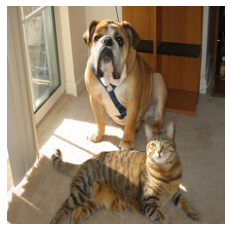

In [3]:
image = Image.open('/content/RISE_tf/examples/catdog.png')
image = np.array(image.resize((224,224)))


plt.figure(facecolor='white')
plt.imshow(image)
plt.axis('off')

Let's define our classifier model for this example. You can use your own custom models too.

In this case the model receives the raw image (no color preprocessing or 
normalization), resized to (224,224,3). 

The color preprocessing actually occurs within the model, which is great for
this purpose and works well for many other XAI libraries too. Tensorflow 2.0 has been adding more preprocessing layer options that make this easier to accomplish. It also makes models easier to share. You can also add your own preprocessing functions to the model architecture. (See: https://www.tensorflow.org/guide/keras/preprocessing_layers)

Importantly, support for custom preprocessing functions outside of the model is 
planned for this repo, but not implemented yet. 

However if you must use a custom external preprocessing function, don't worry. For now you can write a Class that includes your model and the necessary preprocessing functions and pass that model to the explainer instead.

Future steps for this repo include adding an example for such cases, as well better support for custom preprocessing functions outside of the model.

In [4]:
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top = True)
#We freeeze the model weights for classification. 
#This is not actually necessary, but also doesn't have negative effects.
base_model.trainable = False 

input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.applications.vgg19.preprocess_input(inputs) #preprocessing layer.

#Some layers (augmentation layers, batch norm, etc) behave differently during training and inference. 
#To avoid issues with this while using eager execution, we set 'training = False' when calling this model.
out = base_model(x, training = False) #VGG19 pretrained on Imagenet.
model = tf.keras.Model(inputs, out)

574717952/574710816 [==============================] - 4s 0us/step


We use the keras API to get the class names for the top predictions.

It's very straight forward to adapt this for other models in tf.keras.applications.

In [5]:
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

40960/35363 [==================================] - 0s 0us/step
[[('n02108422', 'bull_mastiff', 0.38286775), ('n02108089', 'boxer', 0.22965571), ('n02129604', 'tiger', 0.19323185), ('n02123159', 'tiger_cat', 0.061871562), ('n02110958', 'pug', 0.024822904)]]


To generate the explanation we just need to import the RISE class, instantiate it and pass the image and model to the explaining function.

In [6]:
from RISE_tf.explain_image import RISE

explainer = RISE()
heatmaps, masks = explainer.explain(image,model)

Now that we generated the heatmaps, we can access the ones corresponding to the classes we are interested in. For this case we have classes 243 (bull mastiff) and 281 (tabby cat) within the 1000 Imagenet classes.

(-0.5, 223.5, 223.5, -0.5)

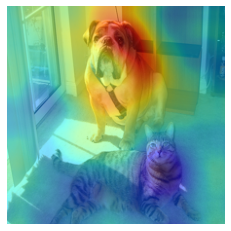

In [7]:
class_idx = 243 #bull mastiff class
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='jet')
plt.imshow(image,alpha=0.5)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

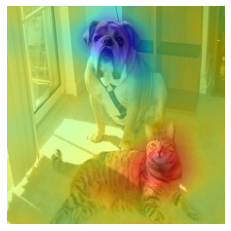

In [8]:
class_idx = 281 #tabby cat
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='jet')
plt.imshow(image,alpha=0.5)
plt.axis('off')

Let's run the same steps again for a couple other images.

In [9]:
image = Image.open('/content/RISE_tf/examples/flute.jpg')
image = np.array(image.resize((224,224)))
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

explainer = RISE()
heatmaps, masks = explainer.explain(image,model)

[[('n03372029', 'flute', 0.99044096), ('n03838899', 'oboe', 0.008851008), ('n03494278', 'harmonica', 0.00036922024), ('n02804610', 'bassoon', 0.00011677682), ('n03840681', 'ocarina', 4.0960866e-05)]]


(-0.5, 223.5, 223.5, -0.5)

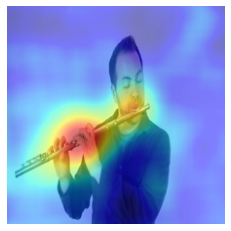

In [10]:
class_idx = 558 #flute, transverse flute
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='jet')
plt.imshow(image,alpha=0.5)
plt.axis('off')

In [11]:
#One last one.

image = Image.open('/content/RISE_tf/examples/shaker.jpg')
image = np.array(image.resize((224,224)))
image_prepared = np.expand_dims(image,0)
y_pred = model.predict(image_prepared)
decoded = tf.keras.applications.vgg19.decode_predictions(y_pred)
print(decoded)

explainer = RISE()
heatmaps, masks = explainer.explain(image,model)

[[('n04131690', 'saltshaker', 0.99848986), ('n03916031', 'perfume', 0.0006037241), ('n04591713', 'wine_bottle', 0.00021616407), ('n03983396', 'pop_bottle', 0.0002099172), ('n03062245', 'cocktail_shaker', 0.00014001089)]]


(-0.5, 223.5, 223.5, -0.5)

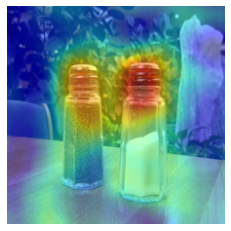

In [12]:
class_idx = 773 #saltshaker
plt.figure(facecolor='white')
plt.imshow(heatmaps[class_idx],cmap='jet')
plt.imshow(image,alpha=0.5)
plt.axis('off')